In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
def numerify(var):
    """
    Cast an object as an int or float if possible. Otherwise return unmodified
    """
    
    if isinstance(var, str):
        try:
            var = int(var)

        except:
            try:
                var = float(var)
            except:
                pass
    else:
        pass
            
    return var

In [3]:
#write a nice data loader
#should return metadata as a dict, data in a pandas df


def read_1D_data(fp):
    """
    Read a 1D Xenocs data .dat file
    """
    metadata = {}
    q = []
    I = []
    sig = []
    header_count = 0

    in_data = False # flag for if we are read into data yet

    with open(fp, 'rt') as f:
        for line in f:
            if not in_data:
                if line[:2] == '##': #metadata section header 
                    header_count +=1
                    continue
                elif line[:2] == '# ':
                    items = line.split()
                    metadata[items[1]] = numerify(items[2])

                elif line[0] == 'q' and header_count == 2:
                    in_data = True
            elif in_data:
                vals = line.split()
                q.append(numerify(vals[0]))
                I.append(numerify(vals[1]))
                sig.append(numerify(vals[2]))


    data = pd.DataFrame({'q':q, 'I':I, 'sig':sig})
    
    return data, metadata
                

        

In [4]:
esaxs_data, esaxs_metadata = read_1D_data('data/Data_0_00002.dat')
saxs_data, saxs_metadata = read_1D_data('data/Data_0_00016.dat')
maxs_data, maxs_metadata = read_1D_data('data/Data_0_00030.dat')

esaxs_bkg_data, esaxs_bkg_metadata = read_1D_data('data/Data_0_00012.dat')
saxs_bkg_data, saxs_bkg_metadata = read_1D_data('data/Data_0_00026.dat')
maxs_bkg_data, maxs_bkg_metadata = read_1D_data('data/Data_0_00040.dat')

## 2. Subtract background

In [5]:
data1 = esaxs_data
data2 = esaxs_bkg_data

#scale data2 onto data1

scale_qmin = 1e-4
scale_qmax = 1e-3

def scale_data(data1, data2, scale_qmin, scale_qmax):
    """
    scale data2 onto data1 using a scale factor calculated from the difference in integrals of data1 and data2 over the range scale_qmin -> scale_qmax
    """

    # get yvals for each dataset
    inrange_data1 = data1[data1['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]
    inrange_data2 = data2[data2['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]

    assert np.isclose(inrange_data1['q'].iloc[0], inrange_data2['q'].iloc[0])
    assert np.isclose(inrange_data1['q'].iloc[-1], inrange_data2['q'].iloc[-1])


    x1 = inrange_data1['q'].to_numpy()
    x2 = inrange_data2['q'].to_numpy()
    y1 = inrange_data1['I'].to_numpy()
    y2 = inrange_data2['I'].to_numpy()
    #check for nans in y values

    #trapezoid rule integrate
    scale1 = np.trapz(y1, x1)/(x1[-1] - x1[0])
    scale2 = np.trapz(y2, x2)/(x2[-1] - x2[0])

    scale_factor = scale1/scale2


    # scale data2 with scale factor
    data2_out = data2.copy()

    data2_out['I'] = data2['I']*scale_factor

    return data2_out


In [9]:
#run subtraction with scaled data

def subtract_background(data, background, scale_background = False, scale_qmin = 1e-4, scale_qmax = 1e-3):

    # check that q values line up for everything
    assert np.isclose(data1['q'].to_numpy(), data2_scaled['q'].to_numpy()).all()
    # once we get fancier look into allowance for slop or interpolation options. For now throw out anything not compliant ^^
    
    if scale_background:
        background = scale_data(data, background, scale_qmin, scale_qmax)

    subtracted_data = data.copy()

    subtracted_data['I'] = subtracted_I
    
    return subtracted_data

In [10]:
#figure out range of data to keep 

In [38]:
a = [1,2,3]

In [40]:
a.pop(0)

1

In [110]:
def ratio_running_average(a, b, n_pts = 10):
    """
    Calculate the running average of the ratio of signal to background
    
    a - signal data. 1d array
    b - background data. 1d array
    """
    
    assert len(a) == len(b), 'a and b must have same number of elements'
    
    ratio = a/b
    
    running_average = np.convolve(ratio, np.ones(n_pts)/n_pts, mode = 'same')
    
    return running_average
    
    

In [111]:
def find_ratio_peak(ratio_avg):
    """
    Find max value of ratio using max
    Returns index of peak
    """
    
    avg_copy = ratio_avg.copy()
    avg_copy[avg_copy == np.inf] = 0
    ind = np.nanargmax(avg_copy)
    
    return ind

In [137]:

signal = esaxs_data
background = esaxs_bkg_data




lowq_thresh = 2
hiq_thresh = 5
hiq_avg_pts = 10
    # def get good data range

    # 1. find lower q limit
    # based on 2x signal in data vs background
def select_valid_data(signal, background, lowq_thresh = 2, hig_thresh = 5, hiq_avg_pts = 10):
    """
    Find the region of valid data in SAXS signal
    
    Considers the ratio of signal to background to identify regions with enough scattering to provide information
    
    Parameters:
    -----------
    signal (DataFrame): signal saxs data
    background (DataFrame): corresponding background
    lowq_thresh: multiplier threshold for low q limit. Signal must be low_thresh times larger than background to find low q limit
    hiq_thresh: threshold for hiq limit
    hiq_avg_pts: how many data points to take a running average over when considering thresholds.
    """

    assert len(signal) == len(background), 'Signal and background data sets need to have same number of data points'

    q = signal['q']

    lowq_lim = None
    hiq_lim = None

    last_n_ratios = []
    rolling_average_ratio = ratio_running_average(signal['I'], background['I'], n_pts = hiq_avg_pts)

    # need to find peak to engage hi-q limit finder
    ratio_peak_ind = find_ratio_peak(rolling_average_ratio)



    for i, ratio in enumerate(rolling_average_ratio):
        if ratio > lowq_thresh:
            if lowq_lim is None:
                lowq_lim = i


        if lowq_lim is not None:
            if i > ratio_peak_ind:
                if ratio < hiq_thresh:
                    if hiq_lim is None:
                        hiq_lim = i
                        break

    return lowq_lim, hiq_lim


In [138]:
select_valid_data(esaxs_data, esaxs_bkg_data)

(11, 466)

In [140]:
esaxs_data['q'][466]

0.07920760516560317

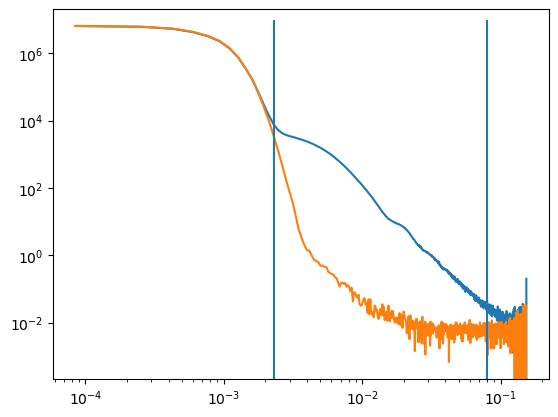

In [149]:
signal = esaxs_data
background = esaxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

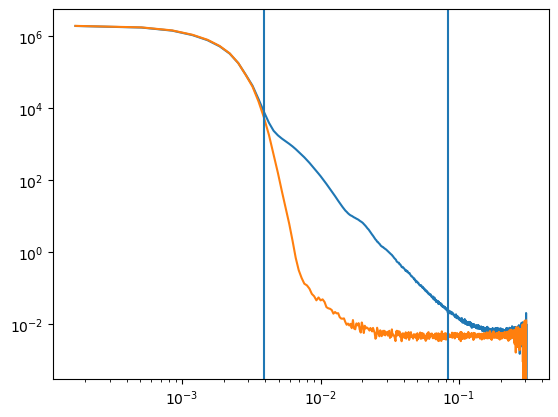

In [152]:
signal = saxs_data
background = saxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

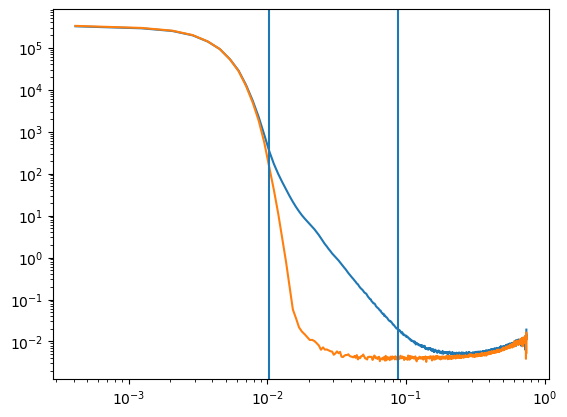

In [154]:
signal = maxs_data
background = maxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

In [48]:
hiq_lim

0.15119908338685878

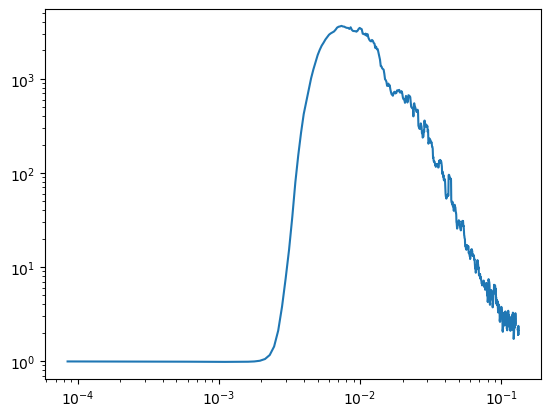

In [45]:
plt.loglog(esaxs_data['q'], rolling_average_ratio)

In [35]:
background_q

0.15357616049793796

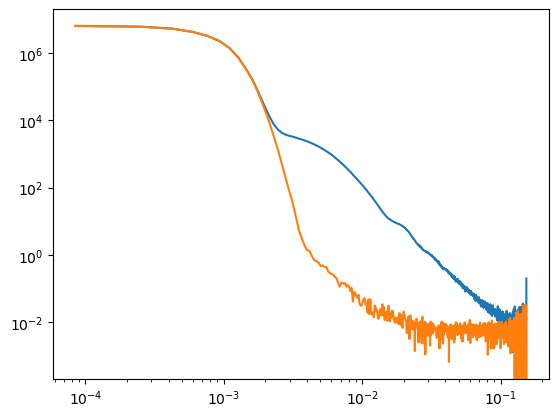

In [7]:
plt.loglog(data1['q'], data1['I'])
plt.loglog(data2_scaled['q'], data2_scaled['I'])

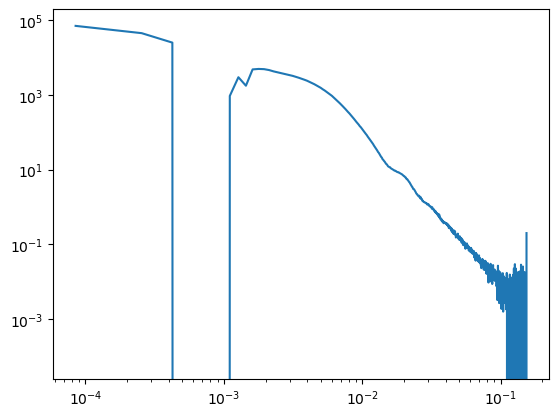

In [38]:
plt.loglog(subtracted_data['q'], subtracted_data['I'])

In [ ]:
saxs_data, saxs_metadata = 

## 3. Data merge

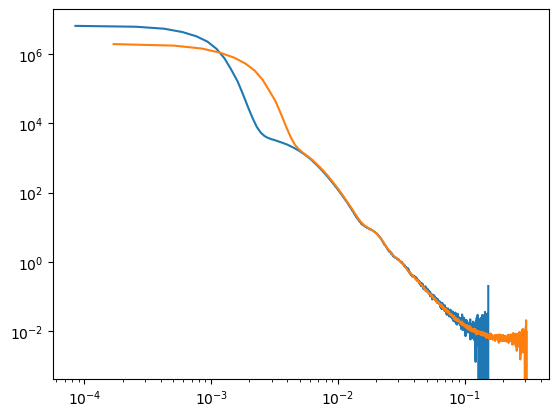

In [8]:
plt.loglog(esaxs_data['q'], esaxs_data['I'])
plt.loglog(saxs_data['q'], saxs_data['I'])

In [ ]:
#1. Figure out 'good' range for each data

#low end: this is hard. probably use hard-coded qmin for now

#upper end: do some sort of noise quantification. Maybe max-min over last 3 data points < 5% of average value? 

# 2. determine overlapping range for the 2 data sets

#3. Looking within overlapping range, apply rules to figure something out

    # - slopes should match
    # - values should be close 
    
    

In [42]:
l = [1,2,3]

In [45]:
l.pop(0)

1

In [46]:
l

[2]

In [65]:
last_3_Is

[0.0, 0.1998208856884082]

In [82]:
#iterate over values in I
last_3_Is = []
variance = []
avg = []
ranges = []


for i, row in data1.iterrows():
    I = row['I']
    if i < 5:
        last_3_Is.append(I)
        continue
    else:
        
        if i == 100:
            print(len(last_3_Is))
        
        last_3_Is.append(I)
        
        Imin = min(last_3_Is)
        Imax = max(last_3_Is)
        Iavg = np.log(np.mean(last_3_Is))
        
        Irange = np.log(Imax) - np.log(Imin)
        avg.append(Iavg)
        ranges.append(Iavg)
        
        var = Irange/Iavg
        
        variance.append(var)
        last_3_Is.pop(0)
        
        
        

# For last 3 values, get min and max val

# min-max should be less than x % of average of last 3 values 


5


/tmp/ipykernel_5466/1559568081.py:24: RuntimeWarning: divide by zero encountered in log
  Irange = np.log(Imax) - np.log(Imin)
/tmp/ipykernel_5466/1559568081.py:22: RuntimeWarning: divide by zero encountered in log
  Iavg = np.log(np.mean(last_3_Is))
/tmp/ipykernel_5466/1559568081.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  Irange = np.log(Imax) - np.log(Imin)


In [83]:
Irange

inf

In [84]:
Iavg

-3.4020933544839136

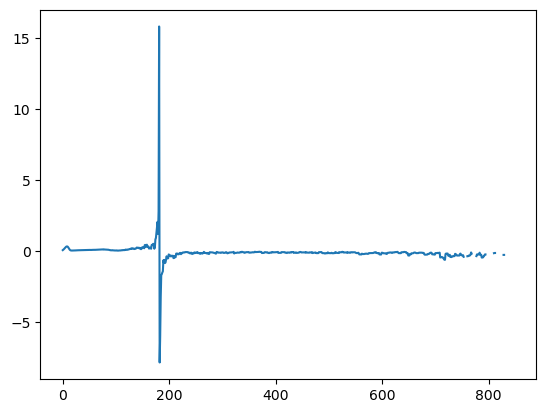

In [85]:
plt.plot(variance)

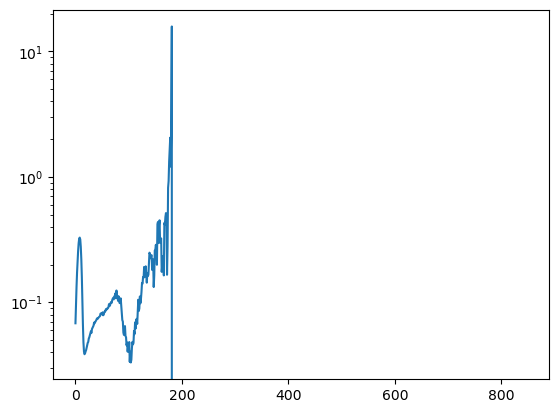

In [86]:
plt.semilogy(variance)

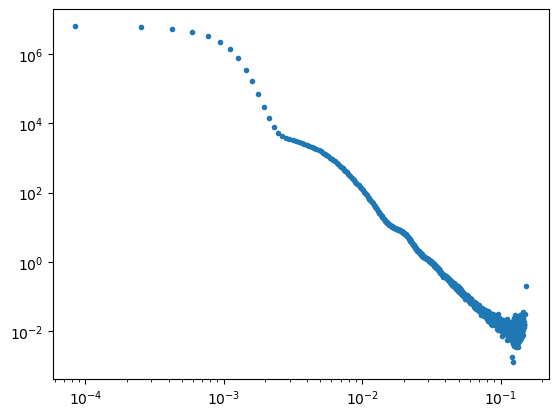

In [81]:
plt.loglog(data1['q'], data1['I'], ls = ' ', marker = '.')